In [52]:
import os
import numpy as np
from datetime import datetime

def parse_timestamp(ts_str):
    return datetime.fromtimestamp(int(ts_str) / 1000.0)

def parse_measurements(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_measurements_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 17:
                continue
            ts = parse_timestamp(parts[0])
            matrix = np.array(list(map(float, parts[1:])), dtype=np.float32).reshape(4, 4)
            parsed.append({'timestamp': ts, 'data': matrix})
    return parsed

def parse_robotstate(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_robotstate_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 25:
                continue
            ts = parse_timestamp(parts[0])
            pose_matrix = np.array(list(map(float, parts[1:17]))).reshape(4, 4)
            joint_config = list(map(float, parts[17:24]))
            state = float(parts[24])
            parsed.append({
                'timestamp': ts,
                'data': pose_matrix,
                'joints': joint_config,
                'state': state
            })
    return parsed

def parse_kalmanfilter(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_kalmanfilter_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 7:
                continue
            ts = parse_timestamp(parts[0])
            position = list(map(float, parts[1:4]))
            velocity = list(map(float, parts[4:7]))
            parsed.append({'timestamp': ts, 'position': position, 'velocity': velocity})
    return parsed

def parse_controller_input(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_controllerinput_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 17:
                continue
            ts = parse_timestamp(parts[0])
            matrix = np.array(list(map(float, parts[1:])), dtype=np.float32).reshape(4, 4)
            parsed.append({'timestamp': ts, 'data': matrix})
    return parsed

def parse_filtered_position(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_filteredposition_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 4:
                continue
            ts = parse_timestamp(parts[0])
            position = list(map(float, parts[1:4]))
            parsed.append({'timestamp': ts, 'position': position})
    return parsed


In [53]:

exp_hash = '#1'
run_number = 1
log_dir = '/dev/shm/experiment'

measurements = parse_measurements(exp_hash, run_number, log_dir)
robotstate = parse_robotstate(exp_hash, run_number, log_dir)
kalman = parse_kalmanfilter(exp_hash, run_number, log_dir)
controller = parse_controller_input(exp_hash, run_number, log_dir)
filtered = parse_filtered_position(exp_hash, run_number, log_dir)



In [54]:
import matplotlib.pyplot as plt

def plot_position_comparison(axis, robotstate, measurements, kalman, controller_input, visibility=[1, 1, 1, 1], time_range=None):
    axis_map = {'x': 0, 'y': 1, 'z': 2}
    if axis not in axis_map:
        raise ValueError("axis must be one of 'x', 'y', 'z'")
    idx = axis_map[axis]

    plt.figure(figsize=(10, 6))

    if visibility[0]:
        rs_time = [entry['timestamp'] for entry in robotstate]
        rs_pos = [entry['data'][:3, 3][idx] for entry in robotstate]
        plt.scatter(rs_time, rs_pos, label='Robot State', s=1)

    if visibility[1]:
        meas_time = [entry['timestamp'] for entry in measurements]
        meas_pos = [entry['data'][:3, 3][idx] for entry in measurements]
        plt.scatter(meas_time, meas_pos, label='Measurements', s=1)

    if visibility[2]:
        kf_time = [entry['timestamp'] for entry in kalman]
        kf_pos = [entry['position'][idx] for entry in kalman]
        plt.scatter(kf_time, kf_pos, label='Kalman Filter', s=1)

    if visibility[3]:
        ctrl_time = [entry['timestamp'] for entry in controller_input]
        ctrl_pos = [entry['data'][:3, 3][idx] for entry in controller_input]
        plt.scatter(ctrl_time, ctrl_pos, label='Controller Input', s=1)

    plt.title(f"{axis.upper()} Position Comparison Over Time")
    plt.xlabel("Time")
    plt.ylabel(f"{axis.upper()} Position (m)")
    plt.legend()
    plt.grid(True)
    if time_range and len(time_range) == 2:
        plt.xlim(time_range[0], time_range[1])
    plt.tight_layout()
    plt.show()

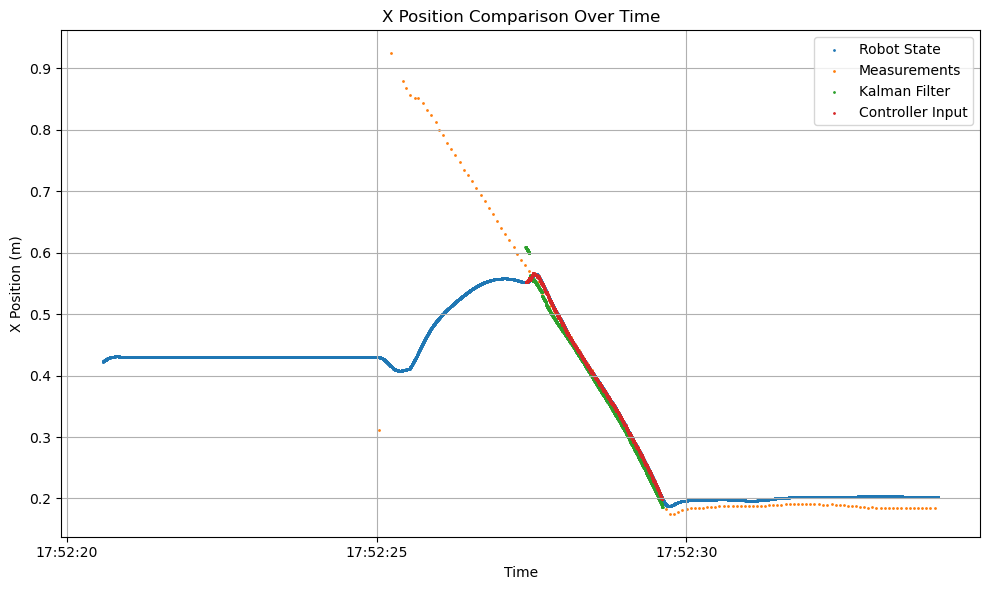

In [59]:
from datetime import datetime

visibility = [1, 1, 1, 1]
time_range = [datetime(2024, 5, 30, 10, 0, 0), datetime(2024, 5, 30, 10, 5, 0)]

plot_position_comparison('x', robotstate, measurements, kalman, controller, visibility)


In [43]:
for i in range(min(5, len(controller))):
    print(controller[i]['timestamp'], controller[i]['data'])

2025-05-30 17:52:27.403000 [[ 0.282562  -0.959124  -0.0148758  0.552308 ]
 [-0.958226  -0.281518  -0.0503102 -0.485518 ]
 [ 0.0440669  0.0284711 -0.998623   0.170509 ]
 [ 0.         0.         0.         1.       ]]
2025-05-30 17:52:27.404000 [[ 0.282562  -0.959124  -0.0148758  0.552304 ]
 [-0.958226  -0.281518  -0.0503102 -0.485522 ]
 [ 0.0440669  0.0284711 -0.998623   0.170499 ]
 [ 0.         0.         0.         1.       ]]
2025-05-30 17:52:27.404000 [[ 0.282562  -0.959124  -0.0148758  0.552301 ]
 [-0.958226  -0.281518  -0.0503102 -0.485526 ]
 [ 0.0440669  0.0284711 -0.998623   0.170489 ]
 [ 0.         0.         0.         1.       ]]
2025-05-30 17:52:27.406000 [[ 0.282562  -0.959124  -0.0148758  0.552299 ]
 [-0.958226  -0.281518  -0.0503102 -0.48553  ]
 [ 0.0440669  0.0284711 -0.998623   0.170479 ]
 [ 0.         0.         0.         1.       ]]
2025-05-30 17:52:27.407000 [[ 0.282562  -0.959124  -0.0148758  0.552297 ]
 [-0.958226  -0.281518  -0.0503102 -0.485534 ]
 [ 0.0440669  0

In [44]:
print(f"Parsed {len(controller)} controller input entries.")


Parsed 2098 controller input entries.


In [45]:
controller = parse_controller_input(exp_hash, run_number, log_dir)


In [51]:
len(robotstate)

13026